IO Homework [Solutions]
=======


### Instructions / Notes:

* This homework, as with the rest of the homeworks in the course, is *not* graded. Although you do not need to turn it in, we expect every student to complete it (and material from it will show up on the final).

Problem 1: External Merge Sort
------------------------

In this problem we'll explore an optimization often referred to as **_double buffering_**, which we'll use to speed up the **external merge sort algorithm** we saw in _Lecture 13_.

Recall that _sequential IO_ (i.e. involving reading from / writing to consecutive pages) is generally much faster that _random access IO_ (any reading / writing that is not sequential). Additionally, on newer memory technologies like SSD reading data can be faster than writing data (if you want to read more about SSD access patterns look [here](http://codecapsule.com/2014/02/12/coding-for-ssds-part-5-access-patterns-and-system-optimizations/). 

For example, if we read 8 consecutive pages from file $A$, this should be much faster than reading 2 pages from $A$, then 4 pages from file $B$, then 2 pages from $A$.

**In this problem, we will begin to model this, by assuming that 8 sequential _READS_ are "free", i.e. the total cost of $8$ sequential reads is $1$ IO. We will also assume that the writes are always twice as expensive as a read. Sequential writes are never free, therefore the cost of $N$ writes is always $2N$.**

### Other important notes:
* **NO REPACKING:** Consider the external merge sort algorithm using the basic optimizations we present in Lecture 13, but do not use the repacking optimization covered in Lecture 13.
* **ONE BUFFER PAGE RESERVED FOR OUTPUT:** Assume we use one page for output in a merge, e.g. a $B$-way merge would require $B+1$ buffer pages
* **REMEMBER TO ROUND:** Take ceilings (i.e. rounding up to nearest integer values) into account in this problem.  Note that we have sometimes omitted these (for simplicity) in lecture.
* **Consider worst case cost:** In other words, if 2 reads _could happen_ to be sequential, but in general might not be, consider these random IO

### Part (a)

Consider a modification of the external merge sort algorithm where **reads are always read in 8-page chunks (i.e. 8 pages sequentially at a time)** so as to take advantage of sequential reads. Calculate the cost of performing the external merge sort for a setup having $B+1=40$ buffer pages and an unsorted input file with $320$ pages.

Show the steps of your work and make sure to explain your reasoning by writing them as python comments above the final answers.

#### Part (a.i)

What is the **exact** IO cost of spliting and sorting the files? As is standard we want runs of size $B+1$.

In [1]:
# Number of runs: (320 pages) / (40 pages/run) = (8 run)
# IO cost/run of reads: ((40 pages/run) / (8 pages/chunk read)) * (1 IO cost/chunk read) = (5 IO cost/run)
# IO cost/run of writes: (40 write/run) * (2 IO cost/write) = (80 IO cost/run)

# To split and sort, we must read every page once and write it out as sorted. 
# We can calculate the number of runs by dividing the number of pages (N) by the run size, B+1.
# We can calculate the IO cost per run of reading by calculating the IO cost of reading the sequential chunks in a run.
# We can calculate the IO cost per run of writing by knowing there will be a write for every page and calculating the IO cost of that.

# Then, we can calculate the IO cost accross all runs by the formula, IO cost = Number of runs * (IO cost/run of reads + IO cost/run of writes)
# IO cost = 8 run * (5 IO cost/run + 80 IO cost/run) = 680 IO cost
io_split_sort = 680

#### Part (a.ii)

After the file is split and sorted, we can merge $n$ runs into 1 using the merge process. What is largest $n$ we could have, given reads are always read in 8-page chunks? Note: this is known as the arity of the merge.

In [2]:
# We can merge up to B runs at once, but since reads are always in 8-page chunks, we can only merge floor(B/8) runs at once. 
# Since B + 1 = 40, B = 39 and we can merge floor(39/8) = 4 runs at once. 
# So n = 4.
merge_arity = 4

#### Part (a.iii)

How many passes of merging are required?

In [3]:
# To merge N pages, we need ceiling(log base n (N/B+1)) passes of merging, where n is the arity of the merge and B+1 is the length of the sorted runs. 
# From the previous parts, we know N = 320, n = 4, and B+1 = 40.
# So # passes = ceiling(log base 4 (320/40)) = 2 pass
merge_passes = 2

#### Part (a.iv)

What is the IO cost of the first pass of merging? Note: the highest arity merge should always be used.

In [4]:
# A single merge pass involves reading all the pages once and writing all the pages once.
# Because reads are always done in chunks, we calculate the IO cost for the number of chunks.
# Write IO cost = number of pages * IO cost/page = 320 * 2 = 640.
# Read IO cost = number of pages / (pages/chunk) * (IO cost/chunk) = 320 / 8 * 1 = 40.
# Single merge pass IO cost = Write IO cost + Read IO cost = 640 + 40 = 680 IO cost.

merge_pass_1 = 680

#### Part (a.v)

What is the total IO cost of running this external merge sort algorithm? **Do not forget to add in the remaining passes (if any) of merging.**

In [5]:
# The total IO cost here will be IO cost of splitting and sorting + IO cost 1 merge pass * 2 passes
# So IO cost = 680 + 680*2 = 2040
total_io = 2040

### Part (b)

Now, we'll generalize the reasoning above by writing a python function that computes the _approximate_* cost of performing this version of external merge sort for a setup having $B+1$ buffer pages, a file with $N$ pages, and where we now read in $P$-page chunks (replacing our fixed 8 page chunks in Part (a)).

**Note: our approximation will be a small one- for simplicity, we'll assume that each pass of the merge phase has the same IO cost, when actually it can vary slightly... Everything else will be exact given our model!* 

We'll call this function `external_merge_sort_cost(B,N,P)`, and we'll compute it as the product of the cost of reading in and writing out all the data (which we do each pass), and the number of passes we'll have to do.

Even though this is an approximation, **make sure to take care of floor / ceiling operations- i.e. rounding down / up to integer values properly!**

**Importantly, to simplify your calculations: Your function will only be evaluated on cases where the following hold:**
* **(B + 1) % P == 0** (i.e. the buffer size is divisible by the chunk size)
* **N % (B + 1) == 0** (i.e. the file size is divisible by the buffer size)

#### Part (b.i)

First, let's write a python function that computes the **exact** total IO cost to create the initial runs:

In [6]:
def cost_initial_runs(B, N, P):
    # 2 * N: writing to the files
    # N / P: reading the files
    return (N * 2) + (N/P)

#### Part (b.ii)

Next, let's write a python function that computes the _approximate_* total IO cost to read in and then write out all the data during one pass of the merge:

In [7]:
def cost_per_pass(B, N, P):
    # N/P: read in all the blocks
    # 2 * N: write out all the blocks
    return (N * 2) + (N/P)

**Note that this is an approximation: when we read in chunks during the merge phase, the cost per pass actually varies slightly due to 'rounding issues'  when the file is split up into runs... but this is a small difference*

#### Part (b.iii)

Next, let's write a python function that computes the **exact** total number of passes we'll need to do

In [8]:
import math
def num_passes(B, N, P):
    # at each step, how many blocks are we joining
    # B / P gets us the number of blocks we can merge(since we need 1 to output),
    # we need to floor it because B might not be divisible by P 
    # final: floor(B/P)
    
    # we have num_of_passes = log_base(floor(B/P))(N/(B + 1)))
    # need to ceiling it since might not be perfect merge
    # final: ceiling(log_base(floor(B/P))(N/B+1))
    # whew!
    return math.ceil(math.log(N/(B + 1), math.floor(B/float(P))))

Finally, our total cost function is:

In [9]:
def external_merge_sort_cost(B, N, P):
    return cost_initial_runs(B,N,P) + cost_per_pass(B,N,P) * num_passes(B,N,P)

### Part (c)

For $B + 1 =100$ and $N=900$, find the optimal $P$ according to your IO cost equation above.  Return both the optimal $P$ value (`P_opt`) and the list of tuples **_for feasible values of $P$_** that would generate a plot of P vs. IO cost, at resolution $=1$(every value of P), stored as `points`:

In [10]:
B = 99
N = 900

feasible_p_range = range(1, B//2)
points = [(p, external_merge_sort_cost(B, N, p)) for p in feasible_p_range]

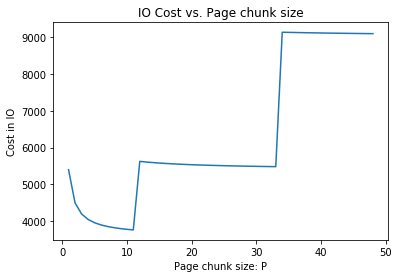

In [11]:
# Shell code for plotting in matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot
plt.plot(*zip(*points))
plt.title("IO Cost vs. Page chunk size")
plt.ylabel("Cost in IO")
plt.xlabel("Page chunk size: P")
plt.show()

What is the optimal Page chunk size, $P_{opt}$? Explain the graph's shape and what happens at $P_{opt}+1$.

In [12]:
# Optimal page chunk size
P_opt = 11

# Shape of graph: the I/O cost decreases from P=0 to 11, then increases significantly
# from P=11 to P=12, then gradually decreases, then increases significantly again from P=33 to P=34, 
# then gradually decreases again

# What happens as P_opt+1: at P_opt+1 (when P=12), the number of passes required 
# jumps from 1 to 2. This drives up the I/O cost.
print('num passes with P_opt:', num_passes(B, N, P_opt))
print('num passes with P_opt_plus_1:', num_passes(B, N, P_opt + 1))

num passes with P_opt: 1
num passes with P_opt_plus_1: 2


Problem 2: IO Cost Models
--------------------------------------


In this problem we consider different join algorithms when joining relations $R(A,B)$, $S(B,C)$, and $T(C,D)$. We want to investigate the cost of various pairwise join plans and try to determine the best join strategy given some conditions.

Specifically, for each part of this question, we are intereseted determining some (or all) of the following variables:

* `P_R`: Number of pages of $R$
* `P_S`: Number of pages of $S$
* `P_RS`: Number of pages of output (and input) $RS$
* `P_T`: Number of pages of $T$
* `P_RST`: Number of pages of output (and input) $RST$
* `B`: Number of pages in buffer
* `IO_cost_join1`: Total IO cost of first join
* `IO_cost_join2`: Total IO cost of second join

#### Note:
* ** The output of join1 is always fed as one of the inputs to join 2 ** 
* **Use the "vanilla" versions of the algorithms as presented in lecture, _i.e. without any of the optimizations we mentioned_**
* **Again assume we use one page for output, as in lecture!**
* ** The abbreviates for the joins used are Sort-Merge Join (SMJ), Hash Join (HJ), and Block Nested Loop Join (BNLJ). **

### Part (a)

Given:
* `P_R`: 20
* `P_S`: 200
* `P_T`: 2000
* `P_RS`: 100
* `P_ST`: 1000
* `P_RST`: 500
* `B`: 32

Compute the IO cost for the following query plans:

* IO_Cost_HJ_1 where only hash join is used, $join1 = R(a,b),S(b,c)$ and $join2 = join1(a,b,c),T(c,d)$
* IO_Cost_HJ_2 where only hash join is used, $join1 = T(c,d),S(b,c)$ and $join2 = join1(b,c,d),R(a,b)$
* IO_Cost_SMJ_1 where only sort merge join is used, $join1 = R(a,b),S(b,c)$ and $join2 = join1(a,b,c),T(c,d)$
* IO_Cost_SMJ_2 where only sort merge join is used, $join1 = T(c,d),S(b,c)$ and $join2 = join1(b,c,d),R(a,b)$
* IO_Cost_BNLJ_1 where only block nested loop join is used, $join1 = R(a,b),S(b,c)$ and $join2 = join1(a,b,c),T(c,d)$
* IO_Cost_BNLJ_2 where only block nested loop merge join is used, $join1 = T(c,d),S(b,c)$ and $join2 = join1(b,c,d),R(a,b)$

**Note: again, be careful of rounding for this problem. Use ceiling/floors whenever it is necessary.**

Include 1-2 sentences (as a python comment) above each answer explaining the performance for each algorithm/query plan.

In [13]:
#P_R: 20
#P_S: 200
#P_T: 2000
#P_RS: 100
#P_ST: 1000
#P_RST: 500
#B: 32 


# P_R fits completely in memory, so no partition phase needed
# IO(join1) = 20 + 200 + 100 OUT = 320

# IO(join2) = 3(100 + 2000) + 500 OUT = 6800
#Total : 6800+320 = 7120

IO_Cost_HJ_1 = 7120 # or 7560 if you chose to partition for join1; we accepted both answers.


# IO(join1) = 3(200 + 2000) + 1000 OUT = 7600

# P_R fits completely in memory, so no partition phase needed
# IO(join2) = 1000 + 20 + 500 OUT = 1520

# Total: 7600+1520 = 9120

IO_Cost_HJ_2 = 9120 # or 11160 if you chose to partition for join2; we accepted both answers.

# join1:
# 1 pass(R/W) to sort R (2 * 20 = 40) 
# 2 pass(R/W) to sort S (4 * 200 = 800) 
# 1 pass(R) to merge (20 + 200 = 220) 
# Total = 40 + 800 + 220 + 100 = 1160  

# join2:
# 2 pass(R/W) to sort RS(4 * 100 = 400) 
# 3 pass(R/W) (B * (B - 1) = 992 < 2000) to sort T (6 * 2000 = 12000) 
# 1 pass(R) to merge (100 + 2000 = 2100)
# OUT = 500
# Total = 400 + 12000 + 2100 + 500 = 15000

# Total = 15000 + 1160 = 16160

IO_Cost_SMJ_1 = 16160

# join1:
# 3 pass(R/W) (B * (B - 1) = 992 < 2000) to sort T (6 * 2000 = 12000)
# 2 pass(R/W) to sort S (4 * 200 = 800)
# 1 pass(R) to merge (200 + 2000 = 2200)
# OUT = 1000
# Total = 12000 + 800 + 2200 + 1000 = 16000

# join2:
# 3 pass(R/W) to sort ST (6 * 1000) = 6000
# 1 pass(R/W) to sort R (2 * 20 = 40)
# 1 pass(R) to merge (20 + 1000 = 1020)
# OUT = 500
# Total = 6000 + 40 + 1020 + 500 = 7560

# Total: 23560

IO_Cost_SMJ_2 = 23560


#join1: 20 + ceiling(20/30) * 200 + 100 = 320
#join2: 100 + ceiling(100/30) * 2000 + 500 = 8600
#Total: 320+8600 = 8920

IO_Cost_BNLJ_1 = 8920

#join1: 200 + ceiling(200/30) * 2000 + 1000 = 15200
#join2: 20 + ceiling(20/30) * 1000 + 500 = 1520 
#Total: 15200 + 1520 = 16720

IO_Cost_BNLJ_2 = 16720

### Part (b)

For the query plan where $join1 = R(a,b),S(b,c)$ and $join2 = join1(a,b,c),T(c,d)$ find a configuration where using HJ for $join1$ and SMJ for $join2$ is cheaper than SMJ for $join1$ and HJ for $join2$. The output sizes you choose for `P_RS` and `P_RS` must be non-zero and feasible (e.g. the maximum output size of $join1$ is `P_R*P_S`). 

In [14]:
# Possible Idea: 
# Have P_R be small while P_S be large. This will result in HJ 
# for join1 being much cheaper using HJ than SMJ for join1

P_R = 10 
P_S = 10000
P_T = 100
P_RS = 50
P_RST = 25
B = 20

# join1: fits in memory, no partition needed
# 10 + 10000 + 50 = 10060
#join2:
# 5 * (100 + 50)  + 25 = 775

HJ_IO_Cost_join1 = 10060
SMJ_IO_Cost_join2 = 775

# join1: 
# sort R: 1 pass (2 * 10 = 20)
# sort S: ceiling(log_base(B)(P_S/B) (8 * 10000 = 80000)
# merge: 10 + 10000 = 10010
# 20 + 80000 + 10010 + 50 = 90080
#join2:
# 3 * (100 + 50) + 25 = 475

SMJ_IO_Cost_join1 = 90080
HJ_IO_Cost_join2 = 475

In [15]:
import math

def HJ_cost_calc(input1, input2, buf, out):
    #From lecture notes, note B is B + 1 in notes
    B = buf - 1
    smaller = min(input1, input2)
    return 2 * math.ceil(math.log(math.ceil(float(smaller)/(B - 1)), B)) * (input1 + input2) + (input1 + input2) + out

def SMJ_cost_calc(input1, input2, buf, out):
    #From lecture notes, note buf is B + 1 in notes
    B = buf - 1
    return 2 * input1 * (1 + math.ceil(math.log(math.ceil(float(input1)/(B + 1)), B))) + \
           2 * input2 * (1 + math.ceil(math.log(math.ceil(float(input2)/(B + 1)), B))) + \
           input1 + input2 + out
        
plan1 = HJ_cost_calc(P_R, P_S, B, P_RS) \
    + SMJ_cost_calc(P_RS, P_T, B, P_RST)
plan2 = SMJ_cost_calc(P_R, P_S, B, P_RS) \
    + HJ_cost_calc(P_RS, P_T, B, P_RST)

print(HJ_cost_calc(P_R, P_S, B, P_RS), SMJ_cost_calc(P_RS, P_T, B, P_RST))
print(SMJ_cost_calc(P_R, P_S, B, P_RS), HJ_cost_calc(P_RS, P_T, B, P_RST))
print(plan1, plan2)

10060 775
90080 475
10835 90555


Problem 3: B+ Trees
-----------------------

In _Lecture 13_ we saw how B+ Trees (a variant of the more general class of B-Trees) can be used to build _indexes_ for quick access to structured data. In this question, you'll get more practice thinking about B+ trees.

For the rest of the question, let's consider the following scenario.  You have a database of 1 billion rows containing a unique *id* and a few other fields. You decide you want to build a B+ tree index on the *id* field of your 1 billion rows.

For simplicity, let's adopt the convention that 1Gigabyte = 1e9 Bytes).

Furthermore:

*   Each page is exactly 4 KB (4000 Bytes)
*   The size of each key in your B+ tree is 8 bytes
*   The size of each pointer in your B+ tree is 8 bytes.




## Part (a)

**Assume that we have a fill-factor of 100% on our B+ tree.**

### Part (a.i)

Each node in the B+ tree structure we build can have between $d$ and $2d$ keys, with the special case that the root node can have between $1$ and $2d$ keys. 

What is the maximum value of $d$ that we can use?

In [16]:
# (2d * 8) + (2d + 1) * 8 <= 4000 => d = 124.
max_value_of_d = 124

### Part (a.ii)

Write a python function that given (the size in bytes of each key, the size in bytes of each pointer, and the number of bytes in a page) returns the largest value of $d$ we can use for our tree.

Run the following assert as well to sanity check your function.


In [17]:
def maximal_degree(key_size, ptr_size, pg_size):
  
  # Solve for d in (2d * key_size) + (2d + 1) * ptr_size = pg_size
  # and return the floor of the result.
  return (pg_size - ptr_size) // (2 * (key_size + ptr_size))

In [18]:
d = maximal_degree(8, 8, 4000)
if d != max_value_of_d:
    raise(Exception("Got {}, expected {}".format(d, max_value_of_d)))

### Part (a.iii)

Fanout is defined as the number of pointers to child nodes coming out of a node.

What is the fanout for our B+ tree? 

In [19]:
# 2d + 1
tree_fanout = 249

### Part (a.iii) cont.

How many index pages are required to index your 1 billion rows?

In [20]:
# ceil(1 billion / 249)
index_pages_required = 4016065

### Part (a.iv)

We now know what value of $d$ we are using as well as the number of index pages we need. What is the height of the B+ tree we need to build?

*  The *height* of the tree is the number of levels in the B+ tree, starting from the root down to the last level before the tree points to data records.
*   Assume that each node in the tree is full with $2d$ keys.



In [21]:
# 249^2 = 62,001 => Not enough index pages at the last level
# 249^3 = 15,438,249 => Enough for the number of index pages we need => Height is Root + 3 levels
min_tree_height = 4

## Part (b)

Let's now think of the I/O costs we expect to incur on our B+ tree.  Let's still keep the assumption that the B+ tree is 100% full.

### Part (b.i)

Your friend comes by and congratulates you on the design of your B+ tree. She claims that it's going to be really efficient because you will only need to do I/O when you fetch *data records* from disk. 

Let's say you are running your database on your shiny new school laptop which has 8GB of memory and infinite hard disk space.

Do you correct your friend, or do you agree and join her in celebrating your awesome B+ tree?

In [22]:
# You correct your friend.  You can only store the first three levels of the tree on memory,
# and you need to store the last level on disk.

# (1 + 249 + 249 ^ 2) * 4000 bytes is about .25 GB, but 
# (1 + 249 + 249 ^ 2 + 249 ^ 3) * 4000 bytes is about 62 GB which will not fit in your memory.
num_levels_of_tree_that_fit_in_memory = 3

### Part (b.ii)

Considering only queries for records with a specific *id* or for a range of *id*s, what is the best case I/O cost and the worst case I/O cost of a query?

In [23]:
# Remeber that 3 of the 4 levels of the tree already fit in memory.

# If you query for a single record, starting from the root you will go down the
# tree in memory until the 4th level. You need to get 1 page from the 4th level,
# then 1 page for the data itself.
# Thus, the total IO cost is 2.
best_case_io_cost = 2

# If you run a range query that results in your retrieving the entire dataset,
# you need to fetch the entire last level of the B+ tree as well as each page
# of the data.
# Because the fill factor is 100% now, there are 249 ** 3 pages in level 4 and
# 249 ** 4 data pages.
worst_case_io_cost = 249 ** 3 + 249 ** 4